# Disaster Tweets with a simple Transformer

In [ ]:
# Ignore warnings when using Tensorflow
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["KMP_SETTINGS"] = "false"

import csv
import pickle
import collections
import numpy as np
import tensorflow as tf
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, layers
from tensorflow_transform import vocabulary, apply_vocabulary
from tensorflow_addons.metrics import F1Score

## Data Preprocessing

The dataset is read and transformed into a suitable format to be processed by Tensorflow. Tweet texts can easily be tokenized using the [TweetTokenizer](https://www.nltk.org/api/nltk.tokenize.html) from `nltk` and we can then build a vocabulary that is used in the input pipline of new data.

In [ ]:
tokenizer = TweetTokenizer()

with open("/kaggle/input/nlp-getting-started/train.csv", "r") as file:
    data = [line[3:5] for line in csv.reader(file)][1:]  # text and target columns
    sentences = [tokenizer.tokenize(d[0]) for d in data]  # tokenized strings
    targets = [int(d[1]) for d in data]  # integer targets

size = len(sentences)
print(f"The dataset contains {size} tweets.")

By quickly counting the number of samples of each class we can confirm that the dataset is not unbalanced to the point where we need to take action and we can proceed.

In [ ]:
collections.Counter(targets)

#### Building the Vocabulary

In order to encode the words as string we need to have a look at the whole vocabulary in the dataset. We then concentrate on the words that appear at least twice and give them an individual index whilst all words appearing only once are encoded as 0.

After all important words have been assigned an index we need to store the mapping in a file such that it can be reused for new words.

In [ ]:
words = [word for sentence in sentences for word in sentence]
word_freq = collections.Counter(words)
words = list(set([word for word, freq in word_freq.items() if freq > 1]))

vsize = len(words) + 1
print(f"The dataset contains {vsize} unique words appearing at least twice.")

with open("/kaggle/working/vocabulary.pkl", "wb") as file:
    pickle.dump(words, file)

We now define a preprocessor object that loads the string to index mappings created before and can be used to encode new sentences as integer vectors. For now we just take a list of strings as input and return the mapped list of integers.

The sentences in the whole dataset can then be transformed into integer vectors such that they can later easily be passed to tensorflow.

In [ ]:
class VocabEncoder():
    def __init__(self, file="/kaggle/working/vocabulary.pkl"):
        with open(file, "rb") as file:
            self.words = pickle.load(file)
            
    def __call__(self, sentence):
        return [self.words.index(word)+1 if word in self.words else 0 for word in sentence]

In [ ]:
encoder = VocabEncoder()
encoded = [encoder(sentence) for sentence in sentences]

#### Splitting into Train and Validation Set

Since we are not particularily interested in the viability of the word encoding we split into train and validation set only now, after the vocabulary has been built. We choose to split 20% of the data off as validation set and stratify by label.

Immediately afterwards we can convert the train and validation set to Tensorflow ragged tensords and build the datasets that can be used for training the models.

In [ ]:
X_train, X_validation, target_train, target_validation = train_test_split(encoded, targets, test_size=0.2, stratify=targets)

In [ ]:
train = tf.ragged.stack([tf.convert_to_tensor(x) for x in X_train]).with_row_splits_dtype(tf.int64)
y_train = tf.one_hot(target_train, depth=2)
validation = tf.ragged.stack([tf.convert_to_tensor(x) for x in X_validation]).with_row_splits_dtype(tf.int64)
y_validation = tf.one_hot(target_validation, depth=2)

## Training the Models

#### Embedding and Logistic Regression

A sentence is represented by the integer sequence of encodings $(w_1, \dots, w_s) \in \mathbb{N}_0^{\times s}$ for sentence length $s \in \mathbb{N}$. We first transform each component to a real number using an embedding $w \mapsto \mathbf{x} \in \mathbb{R}^d$ where we find that embedding dimension $d = 4$ is sufficient. 

To deal with the variable length of the sentences the sequence of embedded vectors $(\mathbf{x}_1, \dots, \mathbf{x}_s)$ needs to be reduced to one single vector. The easiest form of such a reduction is to just take the average
$$ \mathbf{z} = \frac{1}{s} \sum_{i=1}^s \mathbf{x}_i \in \mathbb{R}^s \enspace. $$

Finally, the probabilities of the tweet being about a real disaster or not are computed using a linear transform to the two-dimensional space and a softmax
$$
    p_0 = \frac{e^{\mathbf{w}_0^T\mathbf{z} + b_0}}{e^{\mathbf{w}_0^T\mathbf{z} + b_0} + e^{\mathbf{w}_1^T\mathbf{z} + b_1}} \enspace, \qquad
    p_1 = \frac{e^{\mathbf{w}_1^T\mathbf{z} + b_1}}{e^{\mathbf{w}_0^T\mathbf{z} + b_0} + e^{\mathbf{w}_1^T\mathbf{z} + b_1}} \enspace. 
$$

This model can be visualized as a simple sequence of embedding, reduction and softmax operations.

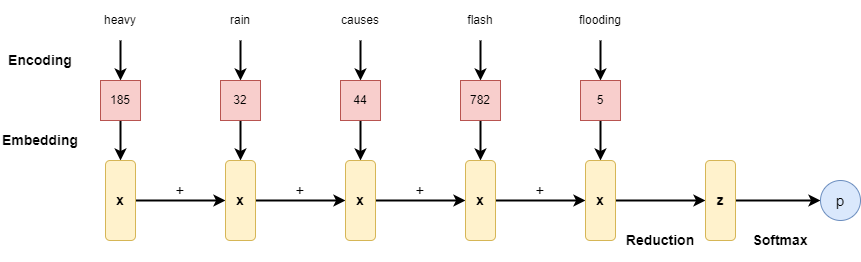

In [ ]:
def define_model(**kwargs):
    input = layers.Input([None], dtype=tf.int32, ragged=True, name="input")
    x = layers.Embedding(vsize, 4, name="embedding")(input)
    x = tf.reduce_mean(x, axis=1, name="reduce")
    x = layers.Dense(2, activation="softmax", name="output")(x)
    return Model([input], [x])

model = define_model()
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=[F1Score(num_classes=2)])
model.summary()

The model can now be trained for 30 epochs after which an F1 score of about 0.8 is achieved.

In [ ]:
model.fit(train, y_train, validation_data=(validation, y_validation), batch_size=64, epochs=30)

#### Recurrent Neural Network

In order to customize the reduction operation a recurrent neural network can be used. It uses the initialization $\mathbf{h}_0 = 0$ and computes hidden states recursively $\mathbf{h}_i = F(\mathbf{x}_i, \mathbf{h}_{i-1}), \, i = 1, \dots, s$ with a learnable transition operation $F$. The reduced sequence is then given by the final hidden state $\mathbf{z} = \mathbf{h}_s$.

The reduction operation is now a generic block that computes a trainable function.

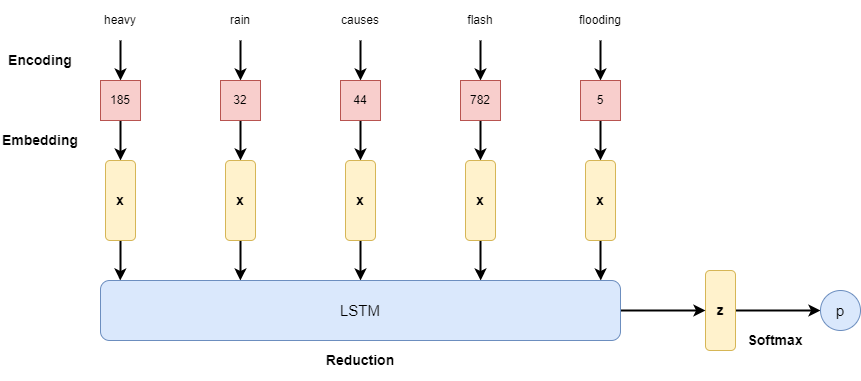

In [ ]:
def define_model(**kwargs):
    input = layers.Input([None], dtype=tf.int32, ragged=True, name="input")
    x = layers.Embedding(vsize, 4, name="embedding")(input)
    x = layers.LSTM(16, name="reduce")(x)
    x = layers.Dense(2, activation="softmax", name="output")(x)
    return Model([input], [x])

model = define_model()
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=[F1Score(num_classes=2)])
model.summary()

Although the reduction operation is now trained, the model performance cannot be improved compared to simply using the sequence average.

In [ ]:
model.fit(train, y_train, validation_data=(validation, y_validation), batch_size=64, epochs=10)

#### Simple Transformer

Since we want to reduce the input sequence to the probabilites of being a tweet about a true disaster we are fine with using transformer encoder blocks to transform the sequence before classifing it. The apply self-attention over the whole sequence to get residual interdependent updates $\mathbf{x}_i \leftarrow \mathbf{x}_i + \sum_{j=1}^s w_{ij}\mathbf{v}_j$ where the attention weights $w_i$ are computed using Luong-style multiplicative attention. It also passes each sequence element through a multi-layer perceptron to increase

Unfortunately, Tensorflow has no support for attention mechanisms and layer normalizations on ragged tensors. For that reason we pad the sequences with zero in the transformer block to a length of 128 which is more than enough to fit any sentece in the training set. 

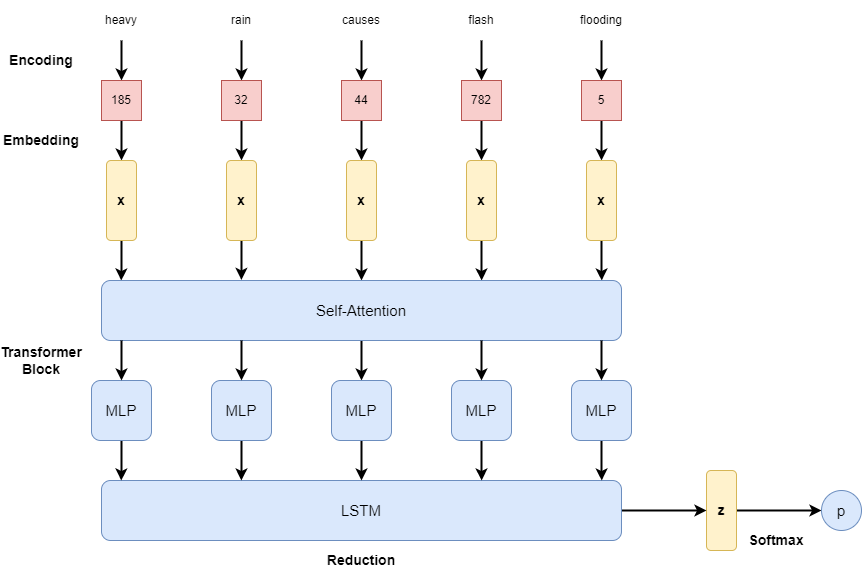

Since the attention layer is not recurrent, it normally does not receive any information about the position of the elements in the input sequence. For that reason we compute a positional encoding that serves as an additional input and is then added to the embedded input words. The encoding of position $k$ in component $i < d$ of the $d$-dimensional embedding vector is given by 
$$
    \sin(10000^{-\frac{2i}{d}}k), \enspace\text{$i$ even}, \qquad \cos(10000^{-\frac{2i-1}{d}}k), \enspace\text{$i$ odd} \enspace.
$$

In [ ]:
embedding_dim = 4

def positional_encoding(length, dim):
    positions = np.arange(length)[:, np.newaxis]
    dims = np.arange(dim)[np.newaxis, :]
    encoding = positions / np.power(10000, (2 * (dims//2)) / dim)
    encoding[:, 0::2] = np.sin(encoding[:, 0::2])
    encoding[:, 1::2] = np.cos(encoding[:, 1::2])
    return tf.stack(encoding)

pos_train = tf.concat([positional_encoding(len(x), embedding_dim) for x in X_train], axis=0)
pos_train = tf.RaggedTensor.from_row_lengths(pos_train, row_lengths=train.row_lengths())
pos_validation = tf.concat([positional_encoding(len(x), embedding_dim) for x in X_validation], axis=0)
pos_validation = tf.RaggedTensor.from_row_lengths(pos_validation, row_lengths=validation.row_lengths())

Using transformer blocks overfits the training set quite easily. However, it seems like generalization can still not be improved over using the embedding layer alone.

In [ ]:
def define_transformer_block(size, hidden_dim, name="transformer"):
    input = layers.Input([None, size], dtype=tf.float32, ragged=True, name=name+"_input")
    x = input.to_tensor(shape=[None, 128, size])
    mask = tf.reduce_all(x == 0, axis=-1)
    
    # Self-Attention
    query = layers.Dense(size, use_bias=False)(x)
    value = layers.Dense(size, use_bias=False)(x)
    key = layers.Dense(size, use_bias=False)(x)
    x = x + layers.Attention()([query, value, key], [mask, mask])
    x = layers.LayerNormalization(axis=(1,2))(x)
    
    # MLP
    x = tf.ragged.boolean_mask(x, mask)
    mlp = layers.TimeDistributed(layers.Dense(hidden_dim, activation="relu"))(x)
    mlp = layers.TimeDistributed(layers.Dense(hidden_dim, activation="relu"))(mlp)
    x = x + layers.TimeDistributed(layers.Dense(size))(mlp)
    x = x.to_tensor(shape=[None, 128, size])
    x = layers.LayerNormalization(axis=(1,2))(x)
    x = tf.ragged.boolean_mask(x, mask)
    return Model([input], [x], name=name)
    
def define_model(**kwargs):
    input = layers.Input([None], dtype=tf.int32, ragged=True, name="input")
    positions = layers.Input([None, embedding_dim], dtype=tf.float32, ragged=True, name="positions")
    x = layers.Embedding(vsize, embedding_dim, name="embedding")(input) + positions
    x = define_transformer_block(4, 4, name="transformer2")(x)
    x = layers.LSTM(16, name="reduce")(x)
    x = layers.Dense(2, activation="softmax", name="output")(x)
    return Model([input, positions], [x])

model = define_model()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[F1Score(num_classes=2)])
model.summary()

In [ ]:
model.fit((train, pos_train), y_train, validation_data=((validation, pos_validation), y_validation), batch_size=64, epochs=10)

## Inference

We first retrain the transformer model on the whole training dataset until we reach a loss function value that has proven to give the best generalization before. Then we can apply the preprocessing pipeline to the test dataset and run the model on them.

In [ ]:
full = tf.concat([train, validation], axis=0)
y_full = tf.concat([y_train, y_validation], axis=0)
pos_full = tf.concat([pos_train, pos_validation], axis=0)

model = define_model()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[F1Score(num_classes=2)])
model.fit((full, pos_full), y_full, batch_size=64, epochs=10)

In [ ]:
with open("/kaggle/input/nlp-getting-started/test.csv", "r") as file:
    test_data = [(line[0], line[3]) for line in csv.reader(file)][1:]  # text and target columns
    test_id = [d[0] for d in test_data]  # row ids
    test_sentences = [tokenizer.tokenize(d[1]) for d in test_data]  # tokenized sentences
    
test_encoded = [encoder(sentence) for sentence in test_sentences]
test = tf.ragged.stack([tf.convert_to_tensor(x) for x in test_encoded]).with_row_splits_dtype(tf.int64)
pos_test = tf.concat([positional_encoding(len(x), embedding_dim) for x in test_encoded], axis=0)
pos_test = tf.RaggedTensor.from_row_lengths(pos_test, row_lengths=test.row_lengths())
y_test = model.predict((test, pos_test))
test_pred = np.argmax(y_test, axis=1)

with open("submission.csv", "w") as file:
    writer = csv.writer(file)
    writer.writerow(("id", "target"))
    for id, pred in zip(test_id, test_pred):
        writer.writerow((id, pred))